# Boundary Layer Height Estimation

This script gets pulls Data (Currently GFS, Will add NARR once I figure it out) data from nomads.ncdc.noaa.gov/ via ftp over a specified date range

### It uses NCL (NCAR Command Language) https://www.ncl.ucar.edu/Download/ to convert .grib2 files to .nc4 (NetCDF4) http://unidata.github.io/netcdf4-python/#netCDF4.Variable

### Then it estimates the BL heights at your location based off the average of the (#9) closet gridpoints

Failed -  gfsanl_4_20170726_1800_000.nc4
Failed -  gfsanl_4_20170727_0000_000.nc4
Failed -  gfsanl_4_20170808_1200_000.nc4
Failed -  gfsanl_4_20170811_1800_000.nc4
Failed -  gfsanl_4_20170812_0000_000.nc4
Failed -  gfsanl_4_20170831_1800_000.nc4


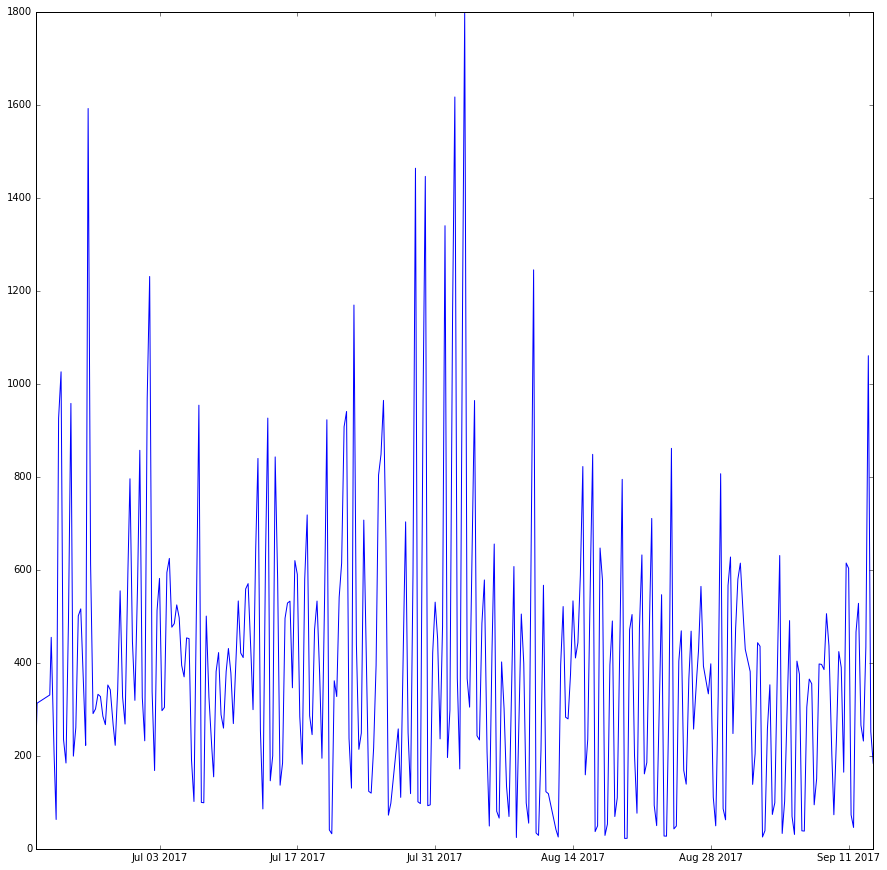

1445.7504122257233


In [3]:
import pandas as pd
import numpy as np
import shlex, subprocess
import matplotlib.pyplot as plt
from functools import partial
from multiprocessing import Pool
import time
from netCDF4 import Dataset

Time = time.time()

ftproot = "ftp://nomads.ncdc.noaa.gov/GFS/analysis_only/"
tail = '_000.grb2'
Data_File = 'FI_Data.csv'


Y_Lat = 69.37333333
X_Lon = -134.89000000+360

def Get_Data(i,Files,Dates,XLon,YLat):
    file,date = Files[i],Dates[i]
    Command = """wget --user="anonymous" --password="thruhikerflash@gmail.com" """
    Command = Command+ file
    args = shlex.split(Command)
    p = subprocess.Popen(args)
    p.wait()
    filename = file.split('/')[-1:][0]
    Command = "ncl_convert2nc "+ filename+" -nc4c"
    args = shlex.split(Command)

    p = subprocess.Popen(args)
    p.wait()

    Command = "sudo rm -rf "+ filename
    args = shlex.split(Command)
    p = subprocess.Popen(args)
    p.wait()
    return(Extract_Data(file,date,XLon,YLat))

def Extract_Data(file,date,XLon,YLat):
    try:
        file = file.split('/')[-1:][0].split('.grb2')[0]+'.nc4'
        with Dataset(file, "a") as Data:

            BL = Data.variables['HPBL_P0_L1_GLL0'][:]
    #             TMP = Data.variables['TMP_P0_L1_GLL0'][:]
            Lat = Data.variables['lat_0'][:]
            Lon = Data.variables['lon_0'][:]
        Command = "sudo rm -rf "+ file
        args = shlex.split(Command)
        p = subprocess.Popen(args)
        p.wait()
        XL = np.where(Lon == Lon[Lon>XLon].min())[0][0]
        YL = np.where(Lat == Lat[Lat>YLat].min())[0][0]
        return(BL[YL:YL+2,XL:XL+2].mean())
    except:
        print('Failed - ', file)
        return(np.nan)
#     self.FluxData.loc[self.FluxData.index == date,'PBLH'] = BL[YL:YL+2,XL:XL+2].mean()
#     print(self.FluxData.loc[self.FluxData.index == date,'PBLH'])



class Get_BL:
    def __init__(self,Data_File,XLon,YLat):
#         self.XLon,self.YLat = X_Lon,Y_Lat
        self.FluxData = pd.read_csv(Data_File,delimiter = ',',header = 0)
        self.FluxData = self.FluxData.set_index(pd.DatetimeIndex(self.FluxData.UTC))
        self.FluxData['PBLH'] = np.nan
        self.File_List()
        
        pools = 4
        pool = Pool(processes=pools)
        

        for i,var in enumerate(pool.imap(partial(Get_Data,Files=self.Files,Dates=self.Dates,XLon=XLon,YLat=YLat),range(len(self.Dates)))):
            self.FluxData.loc[self.FluxData.index == self.Dates[i],'PBLH']=var
        pool.close()
        self.FluxData['PBLH'] = self.FluxData['PBLH'].interpolate()
        plt.figure(figsize = (15,15))
        plt.plot(self.FluxData.index.to_pydatetime(),self.FluxData['PBLH'])
        self.FluxData.to_csv('FI_Data_W_BL.csv')

    def File_List(self):
        self.Files = []
        self.Dates = []
        for i in self.FluxData.index:
            ky = str(i.year)
            mo = str(i.month)
            if i.month < 10:
                mo = '0'+mo
            dy = str(i.day)
            if i.day < 10:
                dy = '0'+dy
            ky1 = ky + mo
            ky2 = ky + mo+ dy
            hr = str(i.hour)+'00'
            if i.hour < 10:
                hr = '0'+hr
            if i.hour%6 == 0:
                if i.minute == 0:
                    self.Files.append(ftproot+ky1+'/'+ky2+'/gfsanl_4_'+ky2+'_'+hr+tail)
                    self.Dates.append(i)
                

if __name__ =='__main__':   
    BL = Get_BL(Data_File,X_Lon,Y_Lat)

plt.show()
print(time.time()-Time)

In [4]:
print(BL.FluxData['PBLH'])

UTC
2017-06-20 12:00:00     260.000000
2017-06-20 12:30:00     277.705453
2017-06-20 13:00:00     295.410905
2017-06-20 13:30:00     313.116358
2017-06-21 20:30:00     330.821811
2017-06-21 21:00:00     348.527263
2017-06-21 21:30:00     366.232716
2017-06-21 22:00:00     383.938169
2017-06-21 22:30:00     401.643621
2017-06-21 23:00:00     419.349074
2017-06-21 23:30:00     437.054527
2017-06-22 00:00:00     454.759979
2017-06-22 00:30:00     436.198313
2017-06-22 01:00:00     417.636648
2017-06-22 01:30:00     399.074982
2017-06-22 02:00:00     380.513316
2017-06-22 02:30:00     361.951650
2017-06-22 03:00:00     343.389984
2017-06-22 03:30:00     324.828318
2017-06-22 04:00:00     306.266652
2017-06-22 04:30:00     287.704987
2017-06-22 05:00:00     269.143321
2017-06-22 05:30:00     250.581655
2017-06-22 06:00:00     232.019989
2017-06-22 06:30:00     217.938323
2017-06-22 07:00:00     203.856658
2017-06-22 07:30:00     189.774992
2017-06-22 08:00:00     175.693326
2017-06-22 08:30